# Data Science Engineering Methods
ML Data Cleaning and Feature Selection

In this assignment, you will use a dataset for predictive learning and check the quality of the data and determine which features are important.

Answer the following questions:

* What are the data types? (Only numeric and categorical)

* Are there missing values?

* What are the likely distributions of the numeric variables?

* Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)

* Which independent variables have missing data? How much?

* Do the training and test sets have the same data?

* In the predictor variables independent of all the other predictor variables?

* Which predictor variables are the most important?

* Do the ranges of the predictor variables make sense?

* What are the distributions of the predictor variables?

* Remove outliers and keep outliers (does if have an effect of the final predictive model)?

* Remove 1%, 5%, and 10% of your data randomly and impute the values back using at least 3 imputation methods. How well did the methods recover the missing values? That is remove some data, check the % error on residuals for numeric data and check for bias and variance of the error.

Notes:

**Normality** - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

**Homoscedasticity** - I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013) Links to an external site.. Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

**Linearity**- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

**Absence of correlated errors** - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

In [ ]:
# Installing libraries
!pip install gender_guesser
!pip install wordcloud
!pip install mlxtend
!pip install eli5

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import gender_guesser.detector as gender
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# fetch dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/RakshitaJ-Neu/info6105-dataset/main/Titanic-Dataset.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# features available in the dataset
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
dataset.shape

(891, 12)

## Examine through data visualization
Now, we can proceed to validate some of our hypotheses by employing visualizations to scrutinize the data.

### Establishing connections among numerical attributes
Let's initiate the process by exploring correlations between numerical attributes and our targeted outcome (Survived).

For analyzing continuous numerical variables such as Age, a histogram chart proves beneficial. Banding or categorizing into ranges aids in identifying meaningful patterns. The histogram visually represents the distribution of samples, employing automatically defined bins or evenly spaced bands. This assists in addressing queries related to specific bands, such as assessing the survival rate of infants.

It's noteworthy that the x-axis in histogram visualizations signifies the count of samples or passengers.

**Observations**

* Infants (Age <=4) exhibited a notably high survival rate.
* The oldest passenger (Age = 80) survived.
* A significant number of individuals aged 15-25 did not survive.
* The majority of passengers fall within the 15-35 age range.

**Decisions**

This straightforward analysis affirms our initial assumptions, guiding decisions for subsequent stages of the workflow.

* We should incorporate Age (our assumption for classification #2) into our model training.
* Address null values in the Age feature (completing #1).
* Implement age groupings (creating #3).

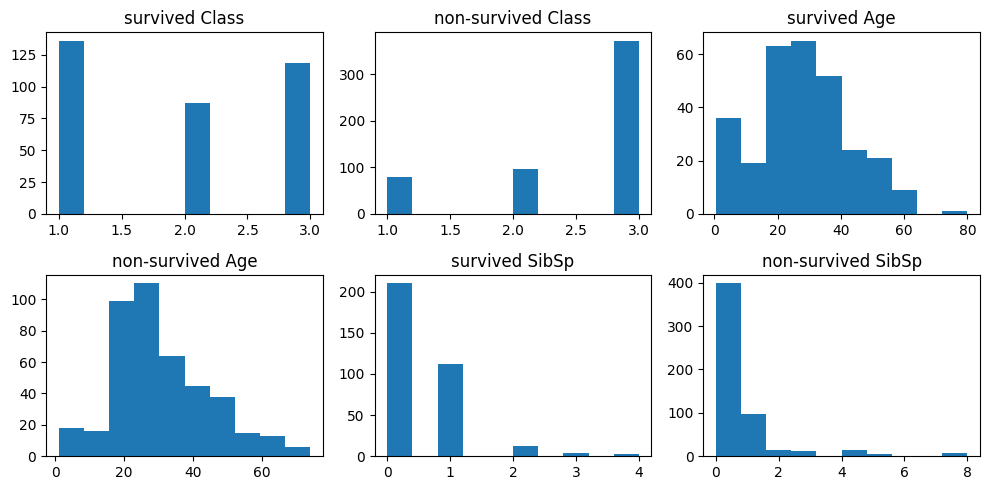

In [ ]:
# Check relationships among the features
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

axes[0][0].hist(dataset[dataset.Survived == 1]['Pclass'])
axes[0][0].set_title('survived Class')

axes[0][1].hist(dataset[dataset.Survived != 1]['Pclass'])
axes[0][1].set_title('non-survived Class')

axes[0][2].hist(dataset[dataset.Survived == 1]['Age'])
axes[0][2].set_title('survived Age')

axes[1][0].hist(dataset[dataset.Survived != 1]['Age'])
axes[1][0].set_title('non-survived Age')

axes[1][1].hist(dataset[dataset.Survived == 1]['SibSp'])
axes[1][1].set_title('survived SibSp')

axes[1][2].hist(dataset[dataset.Survived != 1]['SibSp'])
axes[1][2].set_title('non-survived SibSp')

plt.tight_layout()
plt.show()

### What are the data types? (Only numeric and categorical)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Categorical** features are the values nominal, ordinal, ratio, or interval based. Among other things this helps us select the appropriate plots for visualization.

Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.

**Numerical** features are the values discrete, continuous, or timeseries based. Among other things this helps us select the appropriate plots for visualization.

*Continuous*: Age, Fare, *Discrete*: SibSp, Parch.

Ticket is a mix of numeric and *alphanumeric* data types. Cabin is *alphanumeric*

**Data Preprocessing**

### Are there missing values?

In [ ]:
dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabin, Age and Embarked features contain a number of null values in that order for the training dataset.

In [ ]:
# impute age with median
dataset['Age'].fillna(dataset['Age'].median(),inplace=True)

In [ ]:
dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# convert age as int
dataset['Age'] = dataset['Age'].astype(int)

### Which independent variables have missing data? How much?

In [ ]:
dataset.isnull().sum()/len(dataset)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

### What are the likely distributions of the numeric variables?

To assist us in gauging various initial insights, including the representativeness of the training dataset in relation to the real-world problem domain:

* The dataset comprises 891 samples, which constitute 40% of the total number of passengers on the Titanic (2,224).
* The "Survived" attribute is a categorical feature with binary values, 0 or 1.
* Approximately 38% of the samples represent passengers who survived, aligning closely with the actual survival rate of 32%.
* The majority of passengers (> 75%) did not travel with parents or children.
* Nearly 30% of passengers had siblings and/or spouses on board.
* Fares displayed significant variation, with a small percentage (<1%) of passengers paying as much as $512.
* A negligible proportion (<1%) of elderly passengers fell within the age range of 65-80.

<Figure size 1000x500 with 0 Axes>

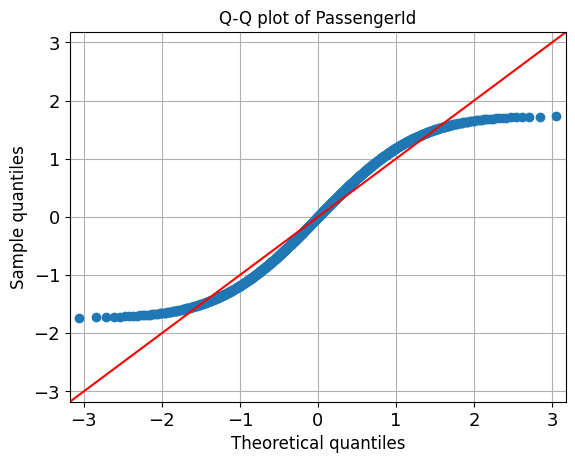

<Figure size 1000x500 with 0 Axes>

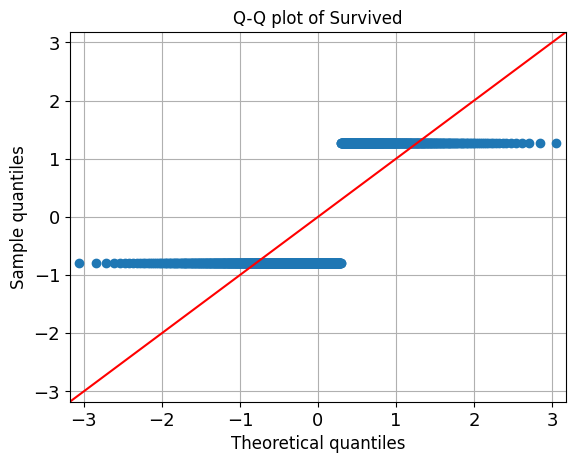

<Figure size 1000x500 with 0 Axes>

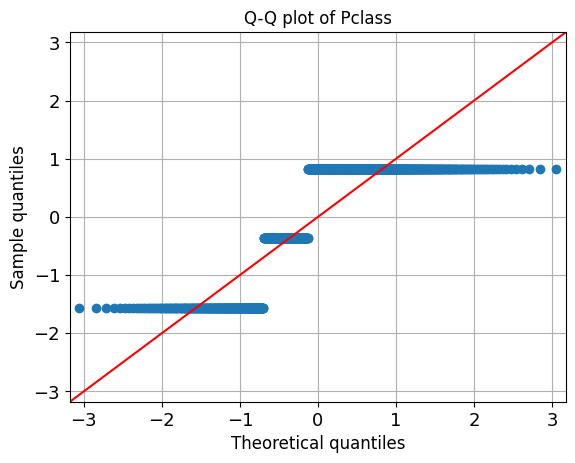

<Figure size 1000x500 with 0 Axes>

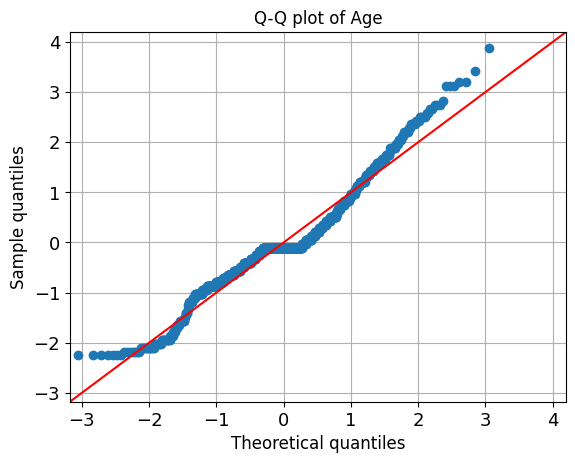

<Figure size 1000x500 with 0 Axes>

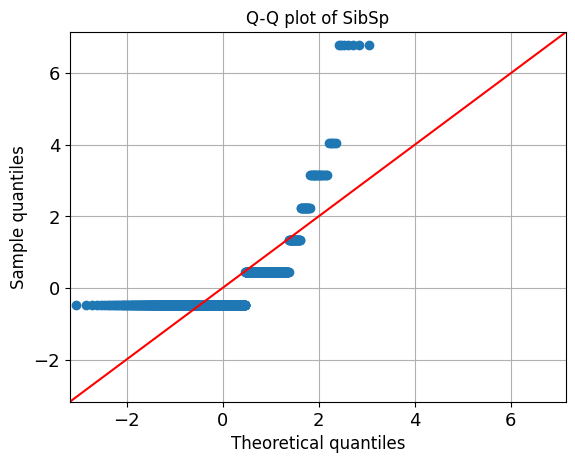

<Figure size 1000x500 with 0 Axes>

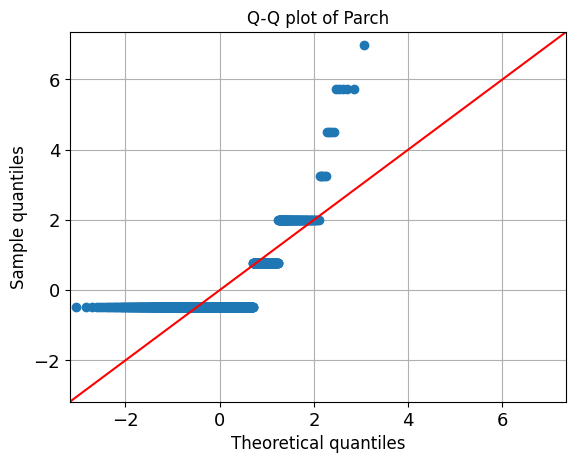

<Figure size 1000x500 with 0 Axes>

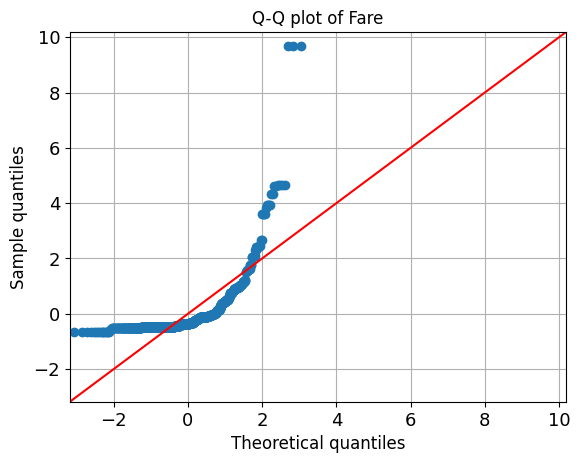

In [ ]:
from statsmodels.graphics.gofplots import qqplot
data_features = dataset[
["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]
]
for c in data_features.columns[:]:
    plt.figure(figsize=(10, 5))
    fig = qqplot(data_features[c], line="45", fit="True")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Theoretical quantiles", fontsize=12)
    plt.ylabel("Sample quantiles", fontsize=12)
    plt.title("Q-Q plot of {}".format(c), fontsize=12)
    plt.grid(True)
    plt.show()

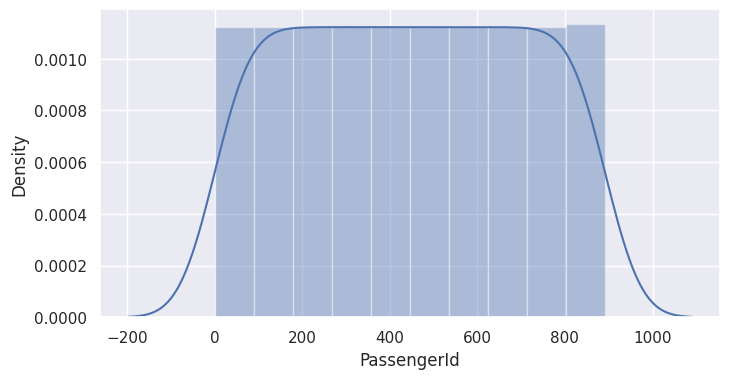

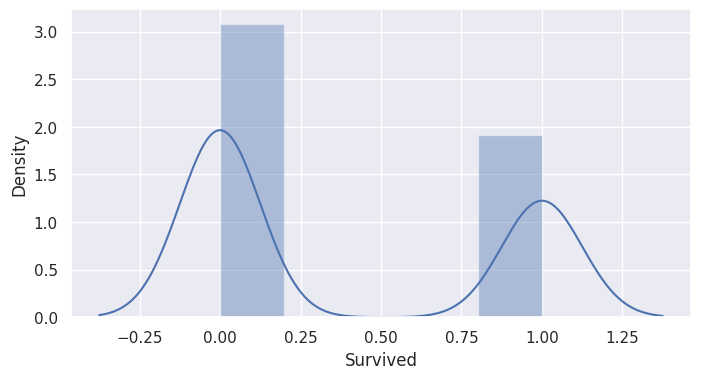

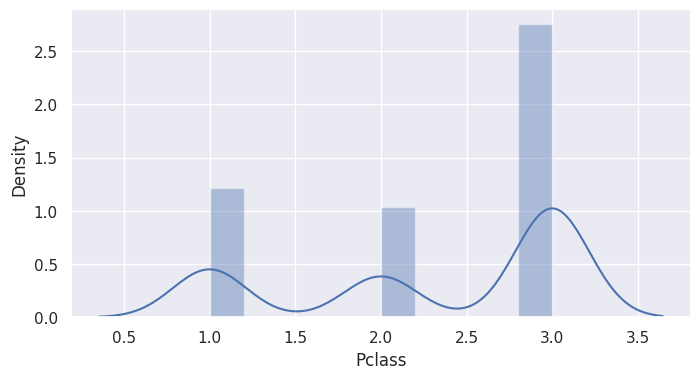

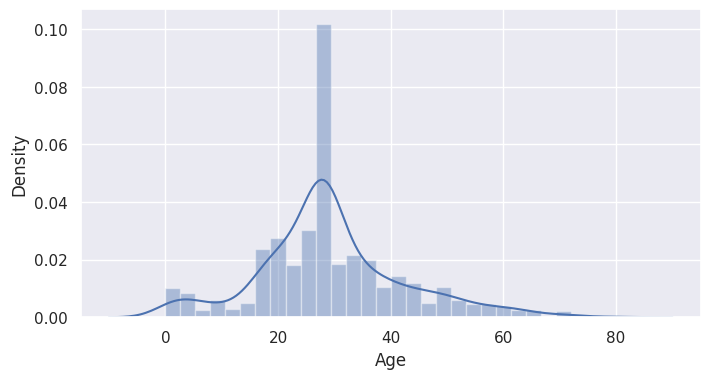

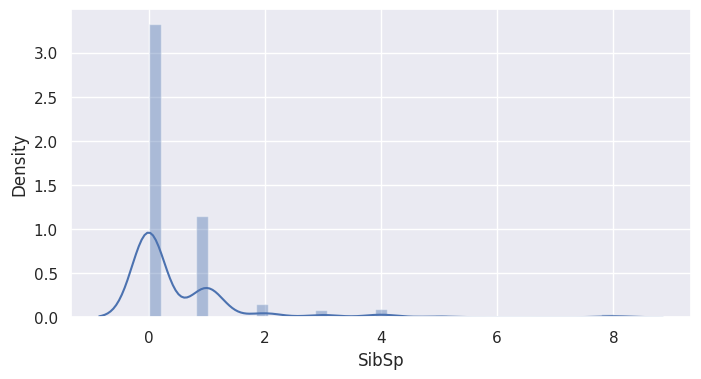

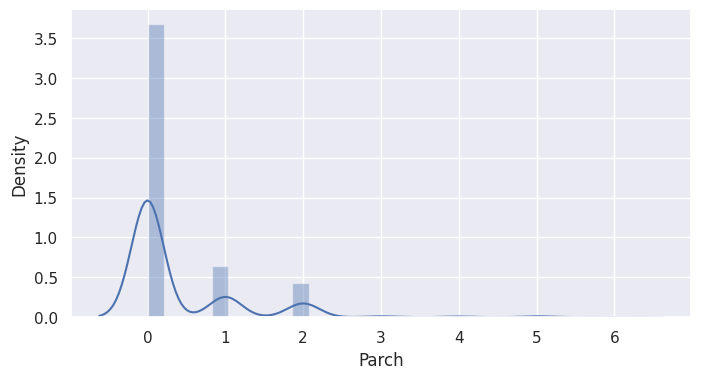

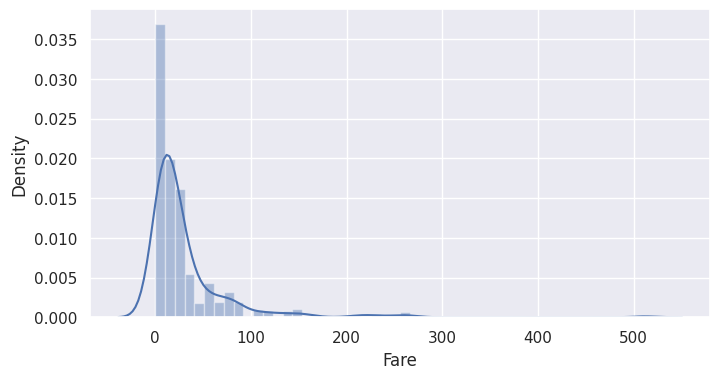

In [ ]:
for column in (dataset[["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]]):
    sns.set(rc={"figure.figsize": (8, 4)});
    sns.distplot(dataset[column])
    plt.show()

### Which independent variables are useful to predict a target (dependent variable)?

### Do the ranges of the predictor variables make sense?

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.345679,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.028212,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


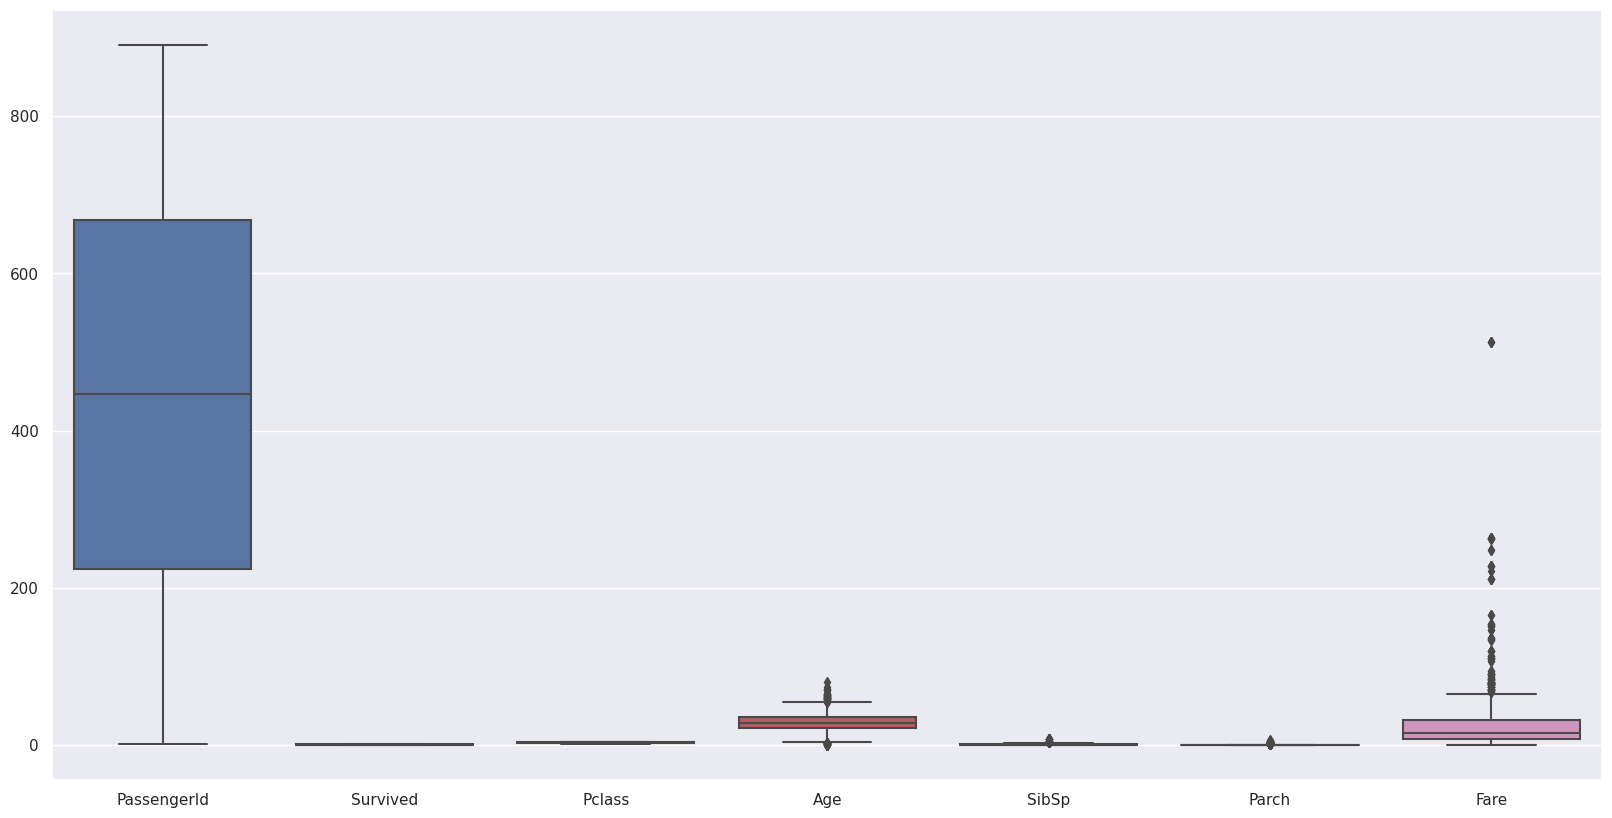

In [ ]:
# To check the Ranges of the predictor variables and dependent variable after normalizing
plt.figure(figsize=(20,10))
sns.boxplot(data = dataset)
dataset.describe()

<Figure size 2000x700 with 0 Axes>

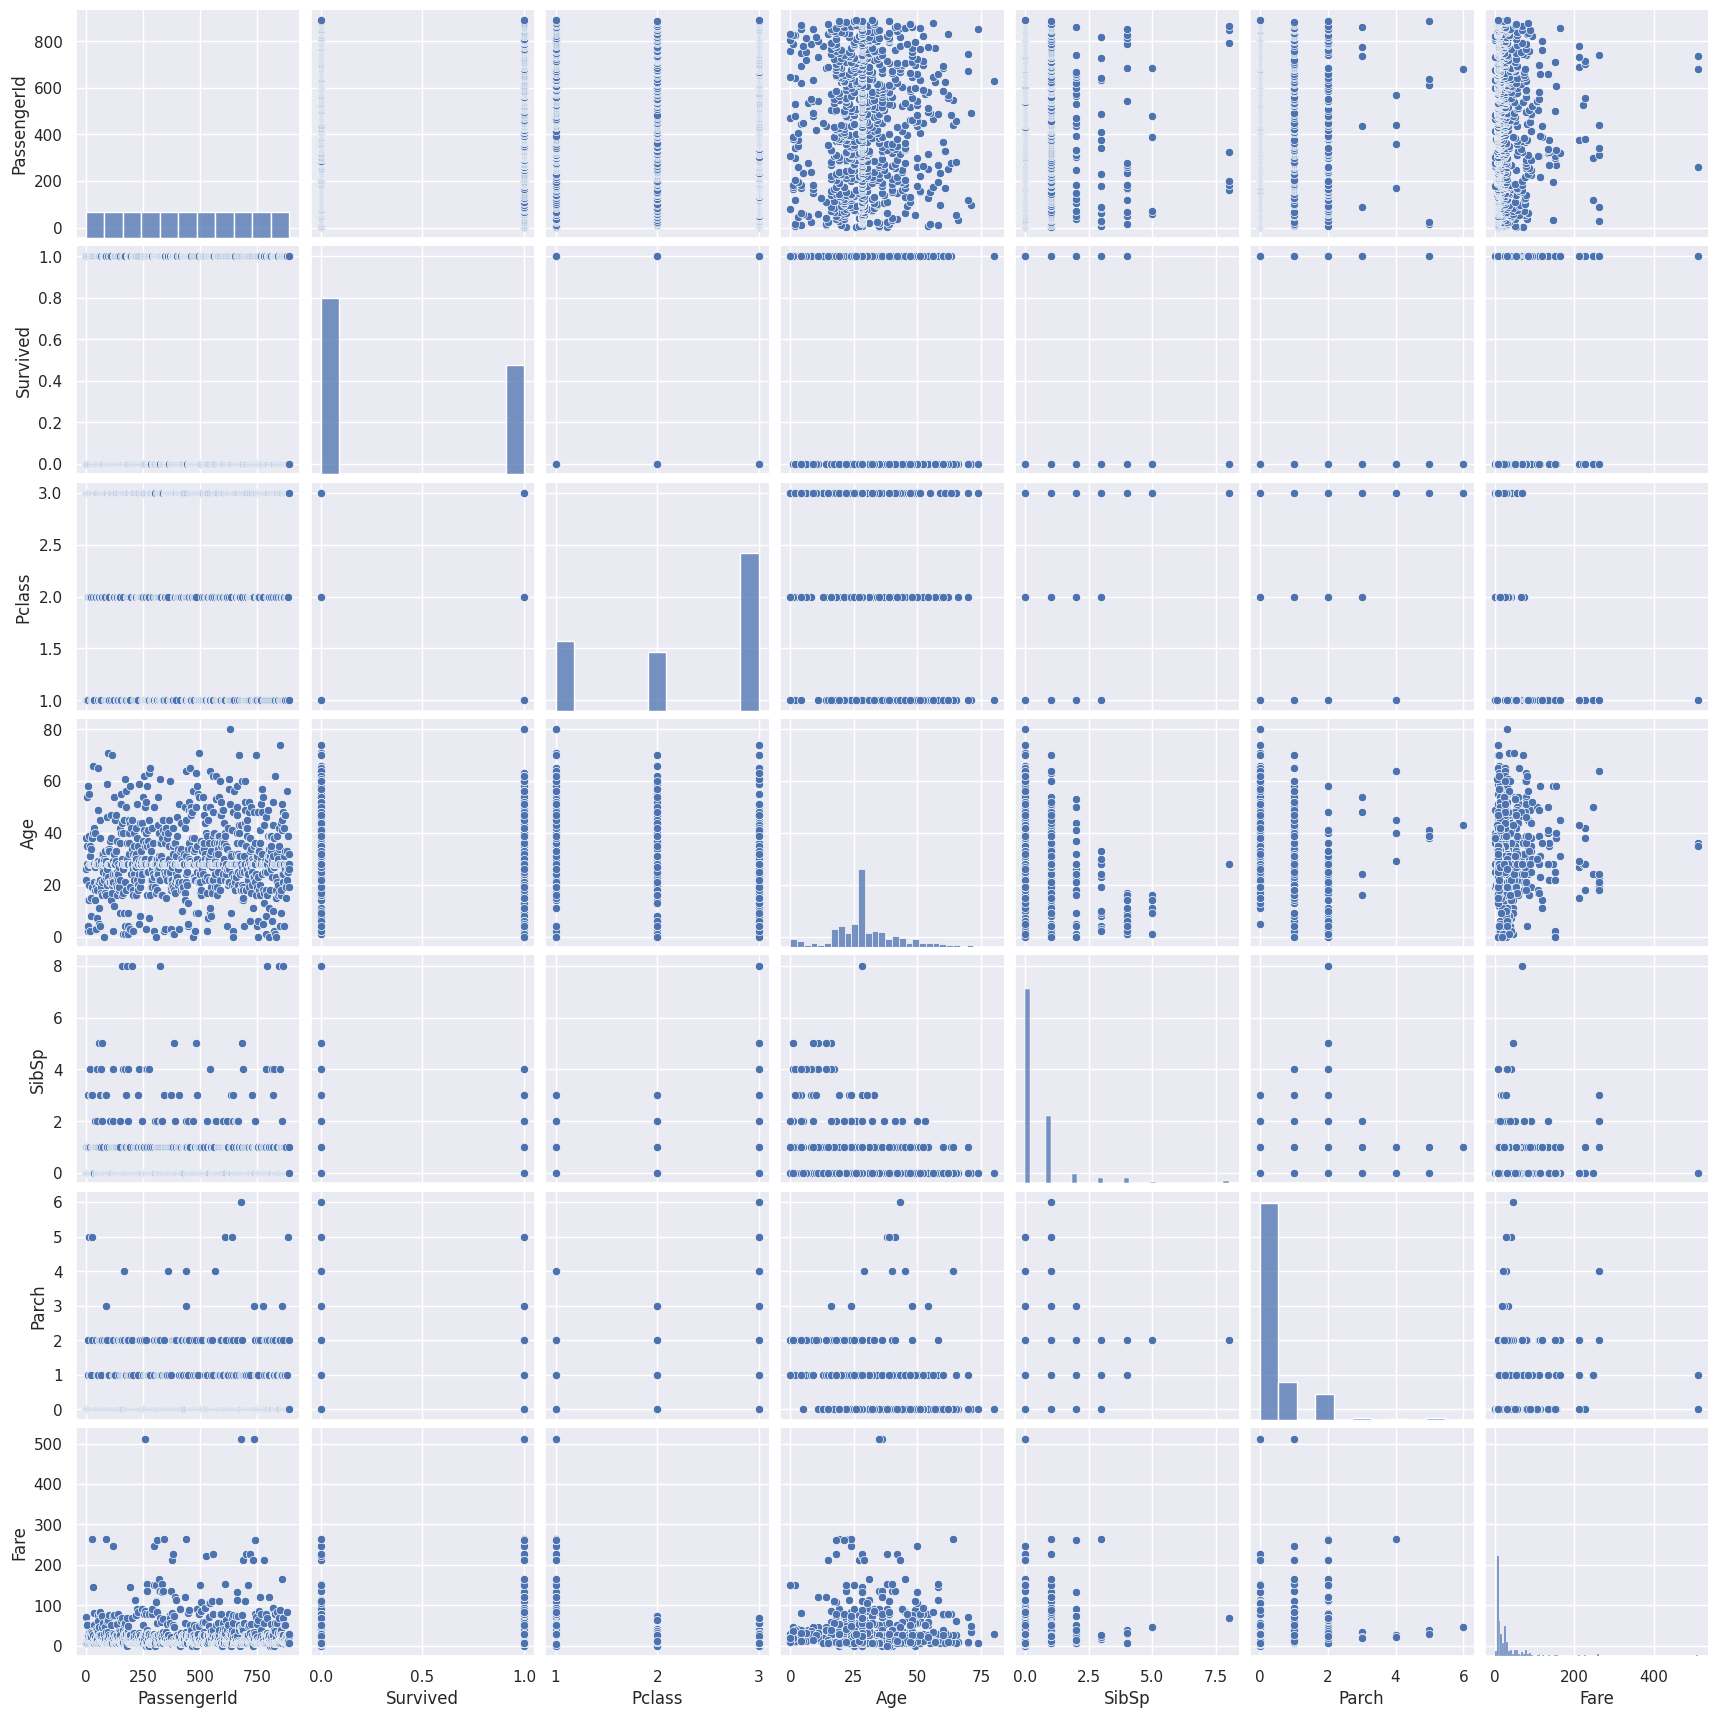

In [ ]:
plt.figure(figsize=(20,7))
sns.pairplot(dataset)

* Correlation matrix and heatmap shows that there is multicollinearity between the independent variables. Heighest correlation is between id and host_id.

In [ ]:
dataset.head()
dataset.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.034322,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.064909,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.339999,0.083081,0.018443,-0.549500
Age,0.034322,-0.064909,-0.339999,1.000000,-0.233066,-0.172745,0.096838
SibSp,-0.057527,-0.035322,0.083081,-0.233066,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.172745,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096838,0.159651,0.216225,1.000000


### In the predictor variables independent of all the other predictor variables?

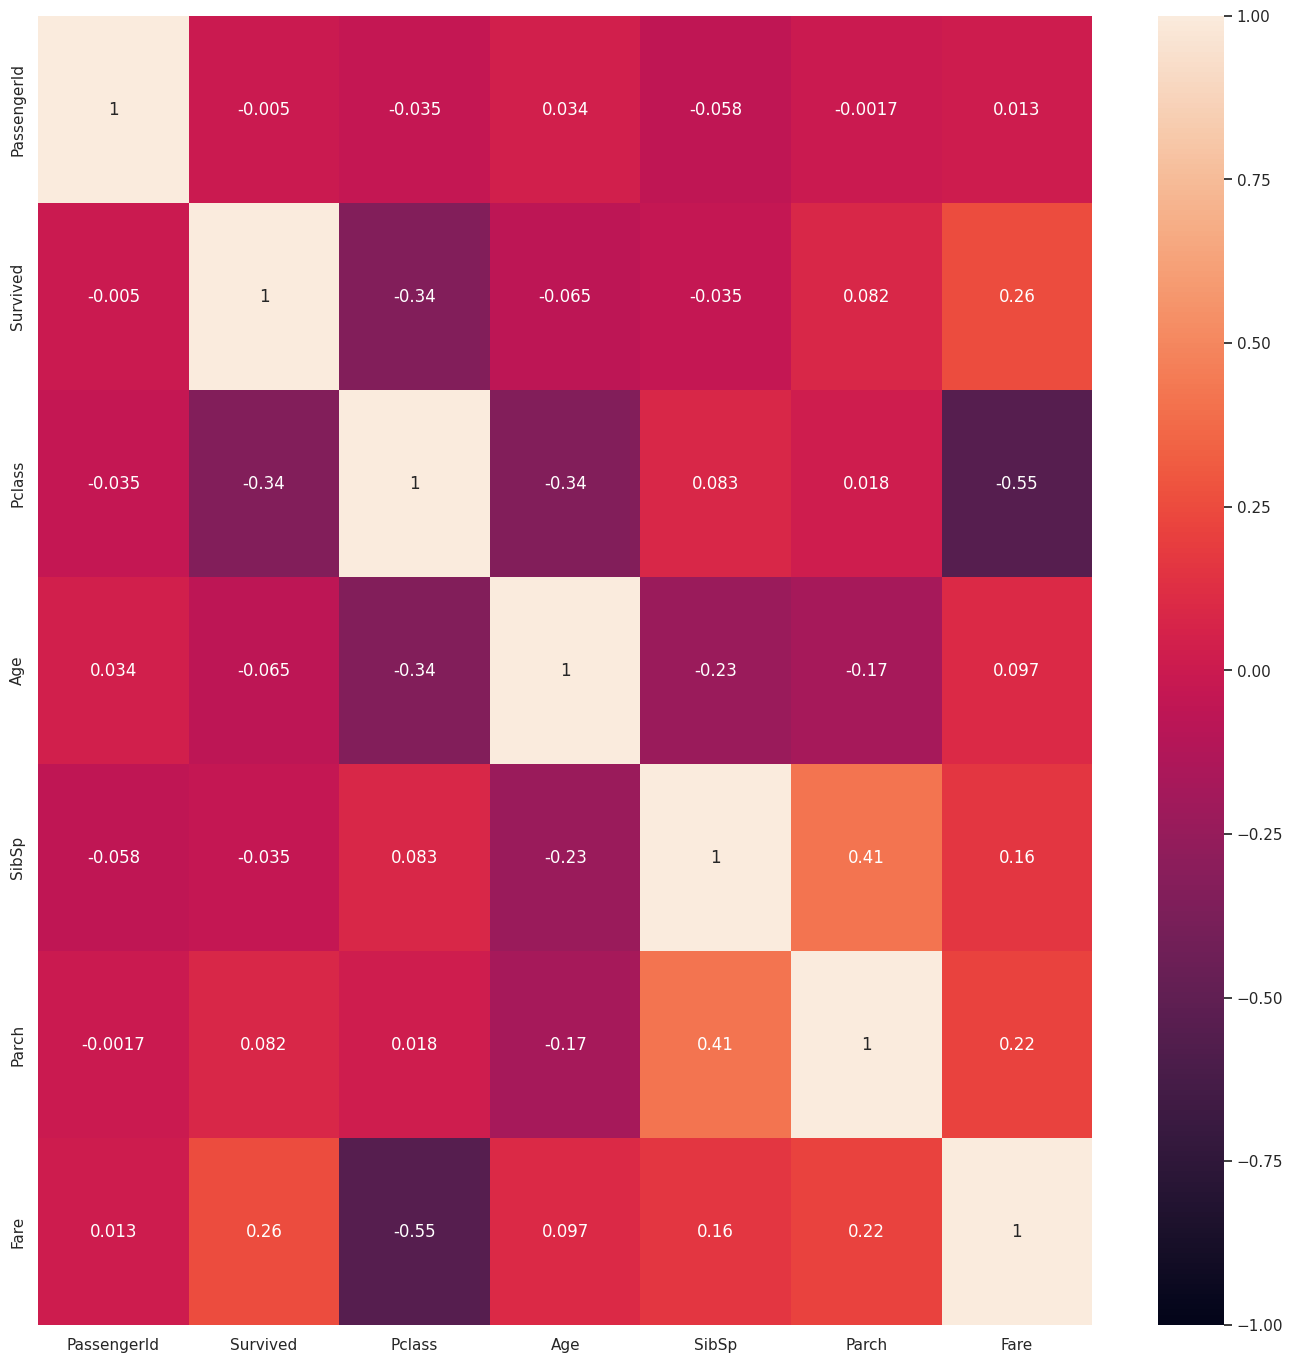

In [ ]:
# show correlation between all features after adding a new one
plt.figure(figsize=(17,17))
cor = dataset.corr()
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

Predictor variables are not independent of all the other predictor variables.For example, (survived and sex) as in Correlation Test, ( sex and SipSp) are Probably dependent. We can also see from the figure that there is collinearity between many variables.

In [ ]:
# drop cabin column
dataset.drop('Cabin',axis=1,inplace=True)

# drop name column, ticket column
dataset.drop(["Name","Ticket"],axis=1,inplace=True)

# drop passenger id
dataset.drop(["PassengerId"],axis=1,inplace=True)

### Data modeling, prediction and solving

Our challenge involves both classification and regression tasks, aiming to establish a connection between the outcome (Survived or not) and various variables or features (Gender, Age, Port, etc.). This falls under the category of supervised learning, where the model is trained using a provided dataset. Considering these two aspects—Supervised Learning and the combination of Classification and Regression—we can narrow down our selection of models to a few candidates. Some of these include:

* Logistic Regression
* KNN (k-Nearest Neighbors)
* Support Vector Machines

### Do the training and test sets have the same data?
No, the training and test sets don't have the same data. The data has been split into a splice of 25% for validation of the model and 75% for training the model.

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
dataset.columns = dataset.columns.str.strip()

In [ ]:
# one hot encode Embarked column and drop it from the original ds
encoded_ds = pd.get_dummies(dataset['Embarked'], prefix='Embarked')
ds_encoded = pd.concat([dataset, encoded_ds], axis=1)
ds_encoded = ds_encoded.drop('Embarked', axis=1)

# one hot encode Class column and drop it from the original ds
encoded_ds = pd.get_dummies(ds_encoded['Pclass'], prefix='Pclass')
ds_encoded = pd.concat([ds_encoded, encoded_ds], axis=1)
ds_encoded = ds_encoded.drop('Pclass', axis=1)

# one hot encode Sex column and drop it from the original ds
encoded_ds = pd.get_dummies(ds_encoded['Sex'], prefix='Sex')
ds_encoded = pd.concat([ds_encoded, encoded_ds], axis=1)
ds_encoded = ds_encoded.drop('Sex', axis=1)

In [ ]:
ds_encoded.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22,1,0,7.2500,0,0,1,0,0,1,0,1
1,1,38,1,0,71.2833,1,0,0,1,0,0,1,0
2,1,26,0,0,7.9250,0,0,1,0,0,1,1,0
3,1,35,1,0,53.1000,0,0,1,1,0,0,1,0
4,0,35,0,0,8.0500,0,0,1,0,0,1,0,1


In [ ]:
# Splitting the data into features and target variable
X = ds_encoded.drop('Survived', axis=1)  # Features
y = ds_encoded['Survived']  # Target variable

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
y_train.describe()

count    712.000000
mean       0.376404
std        0.484824
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

### Logistic Regression
useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution

In [ ]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

80.76

### Support Vector Machines
supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier

In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

66.99

### k-Nearest Neighbors algorithm (or k-NN for short)
non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

83.29

Model Evaluation

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression'],
    'Score': [acc_svc, acc_knn, acc_log]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,KNN,83.29
2,Logistic Regression,80.76
0,Support Vector Machines,66.99


In [ ]:
# preprocessing, mapping values in Sex and Embarked to 0,1 and 0,1,2
dataset['Sex'] = dataset['Sex'].map({'male':0,'female':1})
dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2})

dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22,1,0,7.2500,0.0
1,1,1,1,38,1,0,71.2833,1.0
2,1,3,1,26,0,0,7.9250,0.0
3,1,1,1,35,1,0,53.1000,0.0
4,0,3,0,35,0,0,8.0500,0.0


In [ ]:
#Statsmodel
import statsmodels.api as sm
model = sm.OLS(
    dataset["Survived"],
    dataset[["Pclass", "Age", "Sex", "SibSp", "Parch", "Fare"]]
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Survived   R-squared (uncentered):                   0.575
Model:                            OLS   Adj. R-squared (uncentered):              0.572
Method:                 Least Squares   F-statistic:                              199.4
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                   1.54e-160
Time:                        04:35:11   Log-Likelihood:                         -456.75
No. Observations:                 891   AIC:                                      925.5
Df Residuals:                     885   BIC:                                      954.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass         0.0185      0.011      1.731      0.084      -0.002       0.040
Age            0.0024      0.001      2.829      0.005       0.001       0.004
Sex            0.5800      0.029     19.926      0.000       0.523       0.637
SibSp         -0.0370      0.014     -2.662      0.008      -0.064      -0.010
Parch         -0.0216      0.019     -1.117      0.264      -0.060       0.016
Fare           0.0022      0.000      7.132      0.000       0.002       0.003
==============================================================================
Omnibus:                       41.338   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.905
Skew:                           0.546   Prob(JB):                     1.08e-10
Kurtosis:                       3.214   Cond. No.                         135.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from sklearn.model_selection import train_test_split

# Spliting data into Training 76.5%, Validation set 13.5% and Test set 10%

X_t, X_test, y_t, y_test = train_test_split(dataset[["Pclass", "Age", "Sex","SibSp", "Parch", "Fare"]], dataset["Survived"], test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_t, y_t, test_size=0.15, random_state=1
)

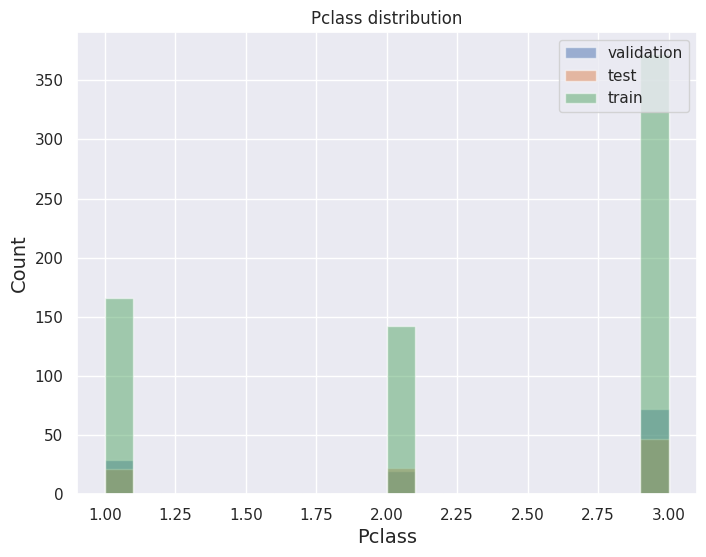

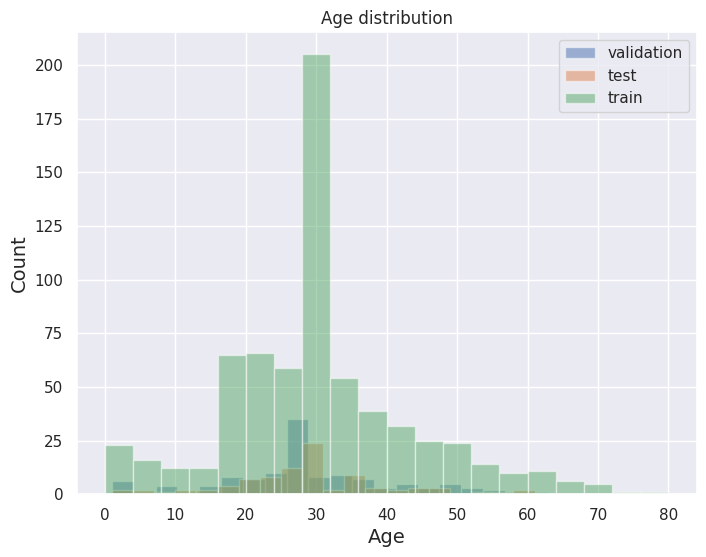

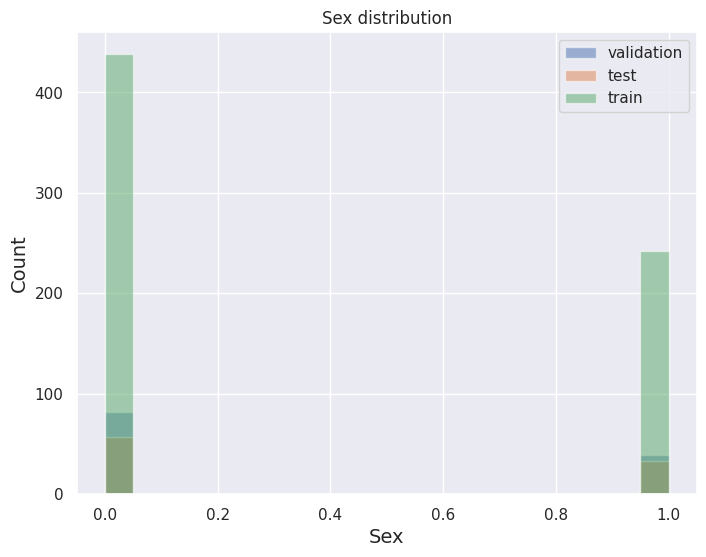

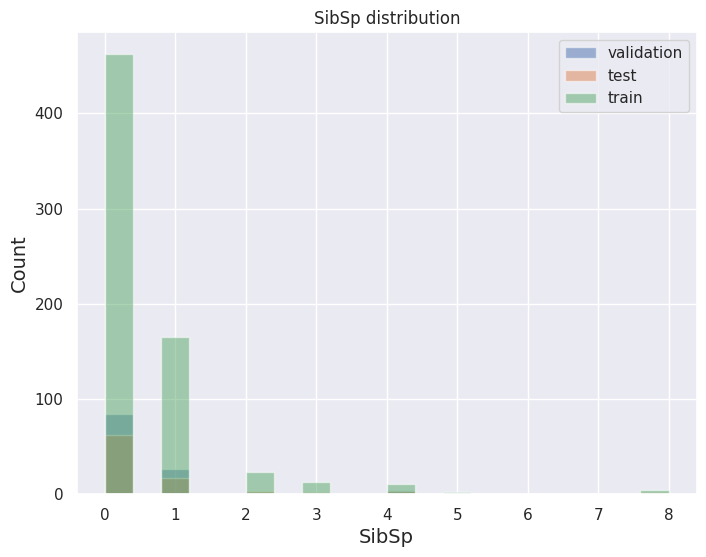

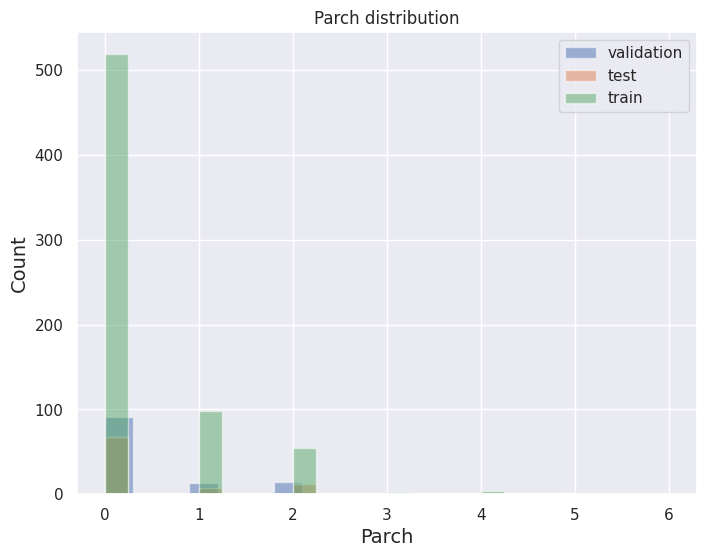

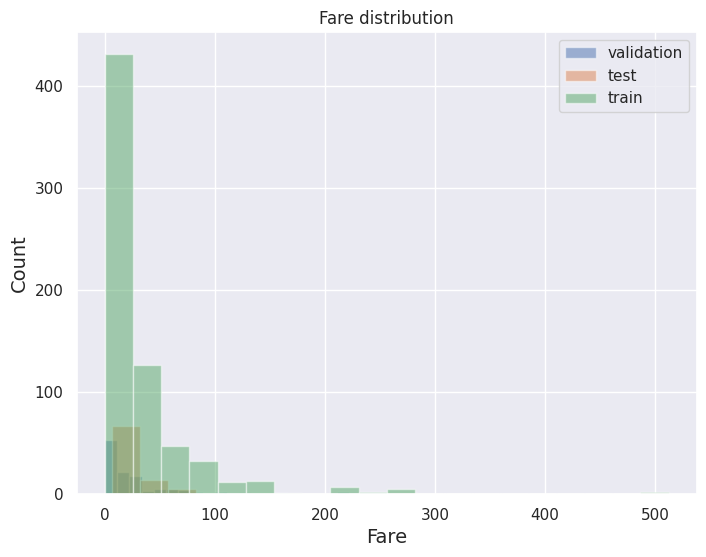

In [ ]:
X_test_plot = X_test[
    [
        "Pclass", "Age", "Sex","SibSp", "Parch", "Fare"
    ]
]

X_val_plot = X_val[
    [
        "Pclass", "Age", "Sex","SibSp", "Parch", "Fare"
    ]
]

X_train_plot = X_train[
    [
        "Pclass", "Age", "Sex","SibSp", "Parch", "Fare"
    ]
]

# Plotting the data to see the histogram
for c in X_test_plot.columns[:]:
    plt.figure(figsize=(8, 6))
    plt.hist(X_val_plot[c], bins=20, alpha=0.5, label="validation")
    plt.hist(X_test_plot[c], bins=20, alpha=0.5, label="test")
    plt.hist(X_train_plot[c], bins=20, alpha=0.5, label="train")
    plt.xlabel(c, size=14)
    plt.ylabel("Count", size=14)
    plt.legend(loc="upper right")
    plt.title("{} distribution".format(c))
    plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

**Logistic Regression** is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution

In [ ]:
# Sequential Forward Selection(sfs)
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
from sklearn.inspection import permutation_importance
results = permutation_importance(logistic_regression, X_train, y_train,scoring = 'accuracy')
importance = results.importances_mean

In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred=(linreg.predict(X_test))

print('R-squared train score: {:.3f}'.format(linreg.score(X_train, y_train)))
print('R-squared test score: {:.3f}'.format(linreg.score(X_test, y_test)))

R-squared train score: 0.409
R-squared test score: 0.350


In [ ]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.05000
Feature: 1, Score: 0.01500
Feature: 2, Score: 0.21853
Feature: 3, Score: 0.00941
Feature: 4, Score: 0.00176
Feature: 5, Score: -0.00324


In [ ]:
#Ridge Regression
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)

y_pred=ridge.predict(X_test)

print('R-squared train score: {:.3f}'.format(ridge.score(X_train, y_train)))
print('R-squared test score: {:.3f}'.format(ridge.score(X_test, y_test)))

R-squared train score: 0.409
R-squared test score: 0.351


In [ ]:
# Make predictions using the training set
y_pred = linreg.predict(X_train)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred))
r2 = r2_score(y_train, y_pred)
print("R^2 score on tarining set =", r2)

Mean squared error: 0.14
Coefficient of determination: 0.41
R^2 score on tarining set = 0.4092493480406908


In [ ]:
# Make predictions using the testing set
y_pred = linreg.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("R^2 score on test set =", r2)

Mean squared error: 0.16
Coefficient of determination: 0.35
R^2 score on test set = 0.3501608292327826


In [ ]:
# Make predictions using the validation set
y_pred = linreg.predict(X_val)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_val, y_pred))
r2_val = r2_score(y_val, y_pred)
print("R^2 score on validation set =", r2_val)

Mean squared error: 0.15
Coefficient of determination: 0.32
R^2 score on validation set = 0.3210053248612418


### Which predictor variables are the most important?

In [ ]:
#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
independent_columns = dataset[["Pclass", "Age", "Sex", "SibSp", "Parch", "Fare"]]  #independent columns
target_column = dataset[["Survived"]]    #target column

#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(independent_columns,target_column)
ds_scores = pd.DataFrame(fit.scores_)
ds_columns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([ds_columns,ds_scores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))  #print best features

         Specs        Score
5   Embarked_Q  4518.319091
2        Parch   170.348127
0          Age    30.873699
1        SibSp    21.688248
4   Embarked_C    10.097499
3         Fare     2.581865
6   Embarked_S          NaN
7     Pclass_1          NaN
8     Pclass_2          NaN
9     Pclass_3          NaN
10  Sex_female          NaN
11    Sex_male          NaN


* Embarked_Q (Score: 4518.319091):

This feature, related to the port of embarkation being Queenstown, has a high importance score of 4518.319091 in the model. It suggests that this feature significantly influences the model's predictions.
* Parch (Score: 170.348127):

The "Parch" feature, representing the number of parents or children aboard, has a substantial importance score of 170.348127. This indicates its considerable impact on the model's predictions.
* Age (Score: 30.873699):

The age of passengers (Age) has a moderate importance score of 30.873699. It contributes to the model's predictions but to a lesser extent compared to the previous features.
* SibSp (Score: 21.688248):

"SibSp," which represents the number of siblings or spouses aboard, has a lower importance score of 21.688248. It still plays a role in the model but is less influential than other features.
* Embarked_C (Score: 10.097499):

This feature, related to the port of embarkation being Cherbourg, has a relatively lower importance score of 10.097499. It contributes to the model, but to a lesser degree compared to the more impactful features.
* Fare (Score: 2.581865):

The fare paid by passengers has a modest importance score of 2.581865, suggesting a limited impact on the model's predictions compared to other features.
* 7-11. Embarked_S, Pclass_1, Pclass_2, Pclass_3, Sex_female, Sex_male (Scores: NaN): features were not considered in the model

In [ ]:
#Classification Problem
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
threshold=0.5
logisticRegr.predict(X_test)

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1])

In [ ]:
s1= logisticRegr.predict(X_test)
rms = mean_squared_error(y_test, s1, squared=False)
rms

0.4472135954999579

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, s1)
print(cf_matrix)

[[46  7]
 [11 26]]


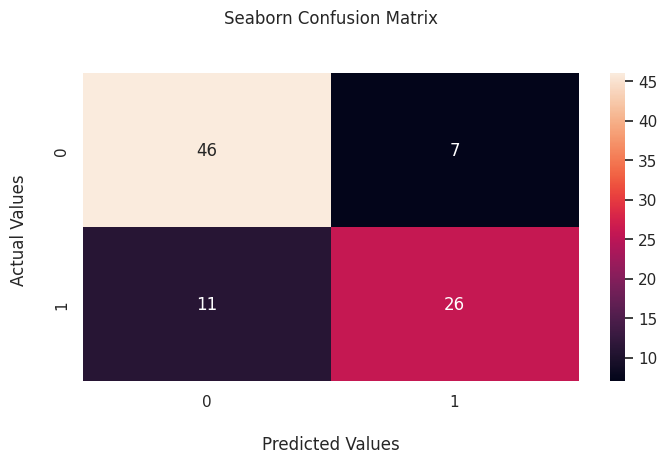

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values \n');

## Display the visualization of the Confusion Matrix.
plt.show()

### Remove outliers and keep outliers (does if have an effect of the final predictive model)?
This dataset doesn't have outliers which are unimportant, as a result, they do form important parts of the **titanic dataset** observations. So no value or test results can be considered as outliers because, they have been performed people Survived

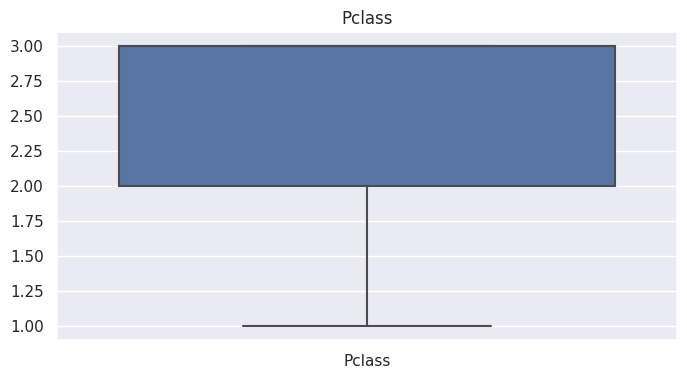

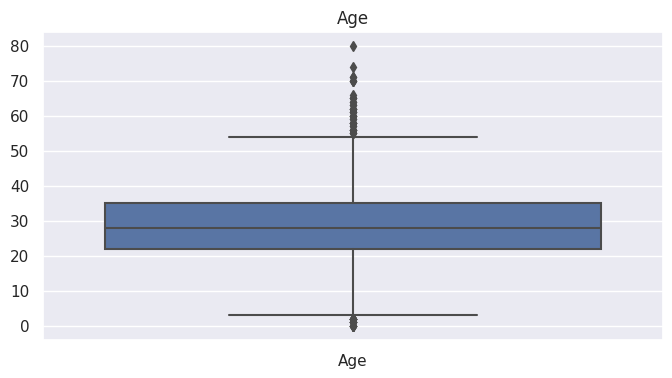

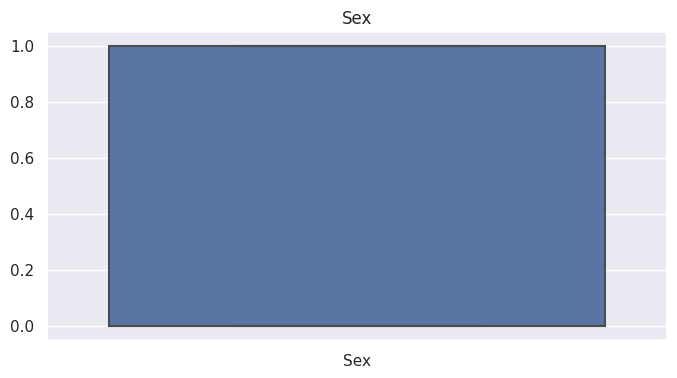

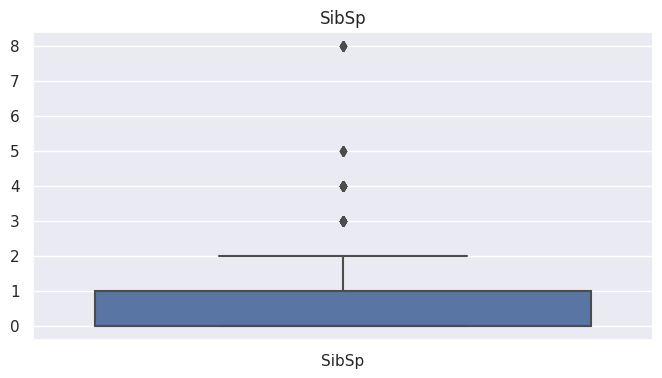

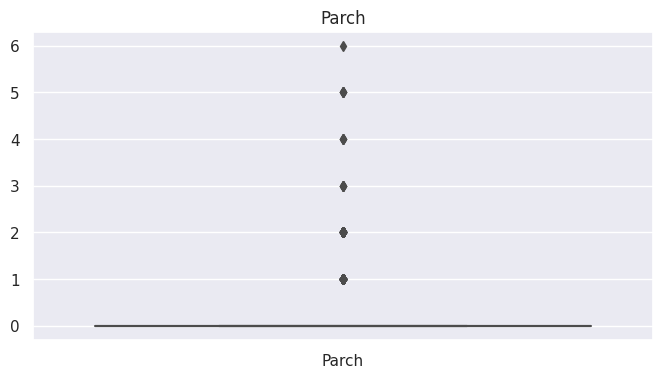

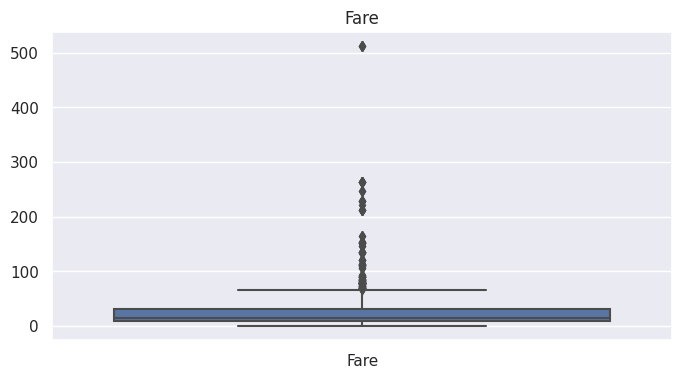

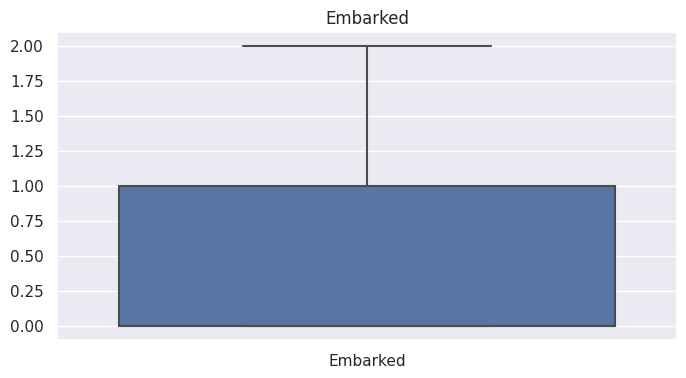

In [ ]:
dataset_t = dataset[["Pclass", "Age", "Sex","SibSp", "Parch", "Fare", "Embarked"]]
for column in dataset_t:
    sns.boxplot(data=dataset[[column]])
    plt.title(column)
    plt.show()

### Remove 1%, 5%, and 10% of your data randomly and impute the values back using at least 3 imputation methods. How well did the methods recover the missing values?

In [ ]:
p = 0.01
mask = np.random.choice([True, False], size = dataset.shape, p = [p, 1 - p])
new_ds = dataset.mask(mask)
print(new_ds)

     Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0.0     3.0  0.0  22.0    1.0    0.0   7.2500       0.0
1         1.0     1.0  1.0  38.0    1.0    0.0  71.2833       1.0
2         1.0     3.0  1.0  26.0    0.0    0.0   7.9250       0.0
3         1.0     1.0  1.0  35.0    1.0    0.0  53.1000       0.0
4         0.0     3.0  0.0  35.0    0.0    0.0   8.0500       0.0
..        ...     ...  ...   ...    ...    ...      ...       ...
886       0.0     2.0  0.0  27.0    0.0    0.0  13.0000       0.0
887       1.0     1.0  1.0  19.0    0.0    0.0  30.0000       0.0
888       0.0     3.0  1.0  28.0    1.0    2.0  23.4500       0.0
889       1.0     1.0  0.0  26.0    0.0    0.0  30.0000       1.0
890       0.0     3.0  0.0  32.0    0.0    0.0   7.7500       2.0

[891 rows x 8 columns]


In [ ]:
#Mean Imputation
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
result = pd.DataFrame(imp.fit_transform(new_ds))
model = sm.OLS(
        result[7],
        result[[0,1,2,3,4,5,6]]
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      7   R-squared (uncentered):                   0.283
Model:                            OLS   Adj. R-squared (uncentered):              0.277
Method:                 Least Squares   F-statistic:                              49.86
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                    7.09e-60
Time:                        04:35:16   Log-Likelihood:                         -828.49
No. Observations:                 891   AIC:                                      1671.
Df Residuals:                     884   BIC:                                      1705.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0831      0.051      1.643      0.101      -0.016       0.182
1              0.1154      0.016      7.022      0.000       0.083       0.148
2              0.1503      0.053      2.831      0.005       0.046       0.255
3           8.286e-05      0.001      0.064      0.949      -0.002       0.003
4             -0.0291      0.022     -1.341      0.180      -0.072       0.013
5             -0.0966      0.029     -3.302      0.001      -0.154      -0.039
6              0.0018      0.000      3.927      0.000       0.001       0.003
==============================================================================
Omnibus:                      208.997   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              372.044
Skew:                           1.482   Prob(JB):                     1.63e-81
Kurtosis:                       4.111   Cond. No.                         195.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Remove 5% data randomly
p = 0.05
mask = np.random.choice([True, False], size = dataset.shape, p = [p, 1 - p])
nu_ds= dataset.mask(mask)
print(nu_ds)

R-squared train score lin-reg: 0.409
R-squared test score lin-reg: 0.350
R-squared train score ridge-reg: 0.409
R-squared test score ridge-reg: 0.351


In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
result = pd.DataFrame(imp.fit_transform(nu_ds))
model = sm.OLS(
        result[7],
        result[[0,1,2,3,4,5,6]]
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      7   R-squared (uncentered):                   0.129
Model:                            OLS   Adj. R-squared (uncentered):              0.122
Method:                 Least Squares   F-statistic:                              18.66
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                    2.74e-23
Time:                        04:35:16   Log-Likelihood:                         -634.93
No. Observations:                 891   AIC:                                      1284.
Df Residuals:                     884   BIC:                                      1317.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0975      0.041      2.364      0.018       0.017       0.178
1              0.0529      0.015      3.437      0.001       0.023       0.083
2             -0.0322      0.045     -0.720      0.471      -0.120       0.056
3              0.0005      0.001      0.367      0.714      -0.002       0.003
4              0.0095      0.021      0.446      0.656      -0.032       0.051
5             -0.0377      0.029     -1.281      0.201      -0.095       0.020
6              0.0006      0.000      1.473      0.141      -0.000       0.001
==============================================================================
Omnibus:                      474.072   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2241.778
Skew:                           2.585   Prob(JB):                         0.00
Kurtosis:                       8.801   Cond. No.                         141.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Remove 10% data randomly
p = 0.1
mask = np.random.choice([True, False], size = dataset.shape, p = [p, 1 - p])
ds_new = dataset.mask(mask)
print(ds_new)

     Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0.0     3.0  NaN  22.0    1.0    0.0   7.2500       0.0
1         1.0     1.0  1.0  38.0    1.0    0.0  71.2833       1.0
2         1.0     3.0  1.0  26.0    0.0    0.0      NaN       0.0
3         1.0     1.0  1.0  35.0    1.0    0.0  53.1000       0.0
4         0.0     NaN  NaN  35.0    0.0    0.0   8.0500       0.0
..        ...     ...  ...   ...    ...    ...      ...       ...
886       0.0     2.0  0.0  27.0    0.0    0.0      NaN       0.0
887       1.0     1.0  1.0  19.0    0.0    0.0  30.0000       NaN
888       0.0     3.0  1.0  28.0    1.0    2.0  23.4500       0.0
889       1.0     1.0  0.0  26.0    0.0    0.0  30.0000       1.0
890       0.0     3.0  0.0  32.0    0.0    0.0   7.7500       2.0

[891 rows x 8 columns]


In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
result = pd.DataFrame(imp.fit_transform(ds_new))
model = sm.OLS(
        result[7],
        result[[0,1,2,3,4,5,6]]
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      7   R-squared (uncentered):                   0.245
Model:                            OLS   Adj. R-squared (uncentered):              0.239
Method:                 Least Squares   F-statistic:                              41.05
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                    3.57e-50
Time:                        04:35:16   Log-Likelihood:                         -823.55
No. Observations:                 891   AIC:                                      1661.
Df Residuals:                     884   BIC:                                      1695.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0718      0.048      1.493      0.136      -0.023       0.166
1              0.1103      0.016      6.839      0.000       0.079       0.142
2              0.1296      0.051      2.565      0.010       0.030       0.229
3             -0.0002      0.001     -0.157      0.876      -0.003       0.002
4             -0.0300      0.022     -1.380      0.168      -0.073       0.013
5             -0.0803      0.030     -2.665      0.008      -0.139      -0.021
6              0.0014      0.000      3.120      0.002       0.001       0.002
==============================================================================
Omnibus:                      238.008   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              460.767
Skew:                           1.607   Prob(JB):                    8.82e-101
Kurtosis:                       4.443   Cond. No.                         177.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above imputations on various %ages of data, we can see that in most of the cases, the column numbers 1, 6, 5, 2 have lowest p-values which means they are highly significant in predicting the correct values of the Survived variable. The names of these columns therefore are -  
1         Age   
6    Embarked  
5        Fare  
2         Sex

Hence, we can conclude these values are highly significant for efficient predictions of the target variable.

Removal of random data and imputation did result in some variations but the overall scope of the variables didn't suffer much.

### Do the ranges of the predictor variables make sense?
Yes, the ranges of the predictor variables they make sense because they are well-defined, in accordance to the units recommended by the researchers those who were capturing these recordings.

## LICENSE
MIT License

Copyright (c) 2023 Rakshita Jaiswal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### REFERENCES
* Dataset- https://www.kaggle.com/datasets/yasserh/titanic-dataset
* OLS Model- http://net-informations.com/ds/mla/ols.html
* Notebooks:
  https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier
  https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests,
  https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier,
  https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/ML_Data_Cleaning_and_Feature_Selection/ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb
* Professor's AutoML Notebook- https://github.com/nikbearbrown/INFO_6105_Data_Science_Engineering_Methods/blob/sorting_branch/Assignment_1/